In [40]:
#Basics
import pandas as pd
import numpy as np

#sklearn
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, precision_recall_curve, roc_auc_score

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(color_codes=True)
pal = sns.color_palette("Set2", 10)
sns.set_palette(pal)

In [41]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load data

In [42]:
df = pd.read_csv('train.csv')
df_predict = pd.read_csv('predict.csv')

### Split data into training and testing sets 

In [43]:
#all columns except survived column
X = df.iloc[:,2:]
# only survived column
y = pd.DataFrame(df['Survived'])
Xtrain1, Xtest1, ytrain1,ytest1 = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify =y)
df_train = pd.merge(Xtrain1, ytrain1, left_index= True, right_index = True)
df_test = pd.merge(Xtest1, ytest1, left_index= True, right_index = True)
df_train.shape, df_test.shape

((712, 11), (179, 11))

In [44]:
df_train.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
692,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S,1
481,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S,0
527,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S,0


### Visualization

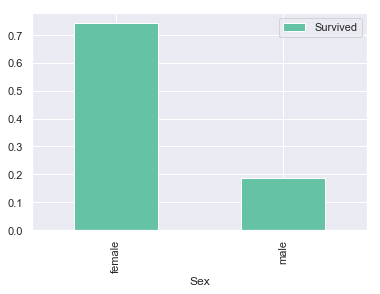

In [45]:
# Gender
pivot_gender = df_train.pivot_table(index="Sex",values="Survived")
pivot_gender.plot.bar()
plt.show()

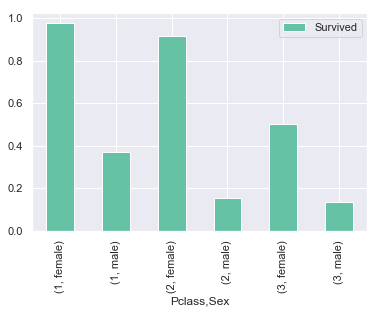

In [46]:
# Gender & Class
pivot_gender = df_train.pivot_table(index=["Pclass","Sex"],values="Survived")
pivot_gender.plot.bar()
plt.show()

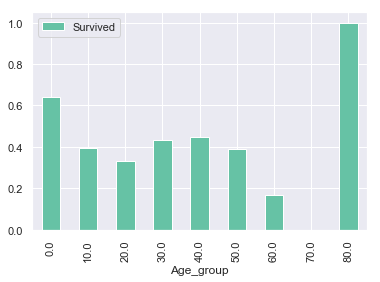

In [47]:
# Agegroup
df_train['Age_group'] =(df_train['Age'] // 10*10)
pivot_age = df_train.pivot_table(index="Age_group",values="Survived")
pivot_age.plot.bar()
plt.show()

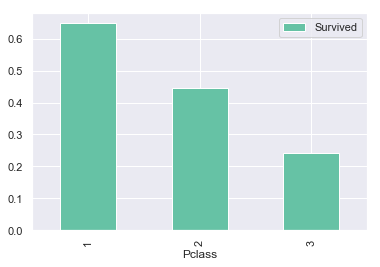

In [48]:
# Class
pivot_class= df_train.pivot_table(index="Pclass",values="Survived")
pivot_class.plot.bar()
plt.show()

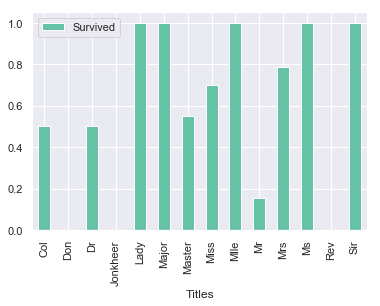

In [53]:
# Title
df_train['Titles'] = df_train['Name'].str.split(r'\s*,\s*|\s*\.\s*').str[1]
pivot_class= df_train.pivot_table(index="Titles",values="Survived")
pivot_class.plot.bar()
plt.show()
df_train.drop(['Titles'], axis=1, inplace=True)


### Clean Data

In [10]:
# missing data
miss = df_train.isna().sum()
miss_perc =(1-df_train.notnull().mean())*100
pd.concat([miss,round(miss_perc)], axis=1,  keys=['missing', 'in %'])

,missing,in %
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,137,19.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,0,0.0
Cabin,552,78.0
Embarked,2,0.0


In [11]:
def cleaning(dataframe):
    ### Age 
    #for dataset in dataframe:
    mean = dataframe['Age'].mean()
    std = dataframe['Age'].std()
    is_null = dataframe['Age'].isnull().sum()
    # compute random numbers
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column
    age_slice = dataframe['Age'].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataframe['Age'] = age_slice
    dataframe['Age'] = dataframe['Age'].astype(int)
    
    ### recoding the gender in two columns
    f = dataframe['Sex'] == 'female'
    dataframe['Gender'] =f.astype(int)
    
    ### defining age groups
    def agegroup(row):
        # age 0-5 
        if row < 6:
            return 1
        # age 6-14 
        elif row < 15:
            return 2
        # age 15-36 
        elif row < 37:
            return 3
        # age 37-55 
        elif row < 56:
            return 4
        # 56-80
        elif row < 81:
            return 5
        else:
            return 6
    dataframe['Agegroup'] = dataframe['Age'].apply(agegroup)
    
    ### recoding the cabin into floor
    # to get starting letter: df_train['Cabin'].str[:1].unique()
    characters = ('N','A','B','C','D','E','F','G','T')
    numbers = ('0','1','2','3','4','5','6','7','8')
    df_deck = pd.DataFrame(
        {'Deck': characters,
         'Deck_No': numbers})
    #replace NaN with N as cabin
    dataframe['Cabin'].fillna('N', inplace=True)
    #Cabin indicator as column
    dataframe['Deck'] = dataframe['Cabin'].str[:1]
    #merge with lookup of level aka deck no
    dataframe = pd.merge(dataframe,df_deck, 
                        on='Deck', 
                        how='left')
    
    ### Embarking ports
    port_dict = {'Q': 1, 'C': 2, 'S':3 }
    dataframe['Ports'] = dataframe['Embarked'].map(port_dict)
    dataframe['Ports'] = dataframe['Ports'].fillna(1)
    
    ### titles
    # how it works:  take the substring that is preceded by , (but do not include), 
    # consists of at least one word character, and ends with a . 
    dataframe['Title'] = dataframe['Name'].str.split(r'\s*,\s*|\s*\.\s*').str[1]
    titles_dummies = pd.get_dummies(dataframe['Title'], prefix='Title')
    dataframe = pd.concat([dataframe, titles_dummies], axis=1)
    
    ### "Women and children first"
    dataframe.loc[( (dataframe['Sex'] == 'female') &     (dataframe['Age'] >= 15) ),    'Category_Code'] = 1
    dataframe.loc[( (dataframe['Sex'] == 'male') &     (dataframe['Age'] >= 15)   ),    'Category_Code'] = 2
    dataframe.loc[(  dataframe['Age'] < 15                                       ),    'Category_Code'] = 3

    return dataframe 


df_train  = cleaning(df_train)
df_test   = cleaning(df_test)
    

In [12]:
# dropping unused columns
def dropping(dataframe):
    dataframe.drop(['Sex'], axis=1, inplace=True)
    dataframe.drop(['Name'], axis=1, inplace=True)
    dataframe.drop(['Ticket'], axis=1, inplace=True)
    dataframe.drop(['Cabin'], axis=1, inplace=True)
    dataframe.drop(['Deck'], axis=1, inplace=True)
    dataframe.drop(['Embarked'], axis=1, inplace=True)

    return dataframe 

df_train  = dropping(df_train)
df_test   = dropping(df_test)

### Build a Logistic Regression model

In [13]:
# Define X and Y for train data
y_train = df_train['Survived']
X_train = df_train[['Age', 'Pclass', 'SibSp', 'Parch', 'Fare','Deck_No','Gender',
             'Title_Master','Title_Miss','Title_Mr','Title_Mrs','Title_Rev',
             'Agegroup','Ports','Category_Code'
             ]]


m = LogisticRegression()

In [14]:
m.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [15]:
m.intercept_, m.coef_

(array([1.96241192]),
 array([[ 0.0038353 , -0.55984594, -0.44176894, -0.32670078,  0.00572036,
          0.24156557,  1.75185455,  1.45283088,  0.13202483, -0.95710557,
          0.85892627, -0.70245537, -0.4452151 , -0.23366142,  0.15030563]]))

In [16]:
m.score(X_train,y_train)

0.8398876404494382

In [17]:
# Define X and Y for test data
y_test = df_test['Survived']
X_test = df_test[['Age', 'Pclass', 'SibSp', 'Parch', 'Fare','Deck_No','Gender',
             'Title_Master','Title_Miss','Title_Mr','Title_Mrs','Title_Rev',
             'Agegroup','Ports','Category_Code'
             ]]


In [18]:
m.score(X_test,y_test)

0.8324022346368715

In [19]:
df_predict=pd.DataFrame(m.predict_proba(X_train), columns = ['Survived_No', 'Survived_Yes'])
df_predict.round(decimals=2)
df_predict.head(3)

,Survived_No,Survived_Yes
0,0.914305,0.085695
1,0.850583,0.149417
2,0.313601,0.686399


### Merge Data

In [20]:
df_predict2 = pd.merge(df_test,df_predict, left_index= True, right_index = True)
#df_predict2.head(3)

In [21]:
y_pred =m.predict(X_train)
confusion_matrix(y_pred, y_train)

array([[393,  68],
       [ 46, 205]], dtype=int64)

In [22]:
precision_score(y_pred=y_pred, y_true=y_train)

0.8167330677290837

In [23]:
recall_score(y_true=y_train,y_pred=y_pred)

0.7509157509157509

### Precision-Recall-Curve

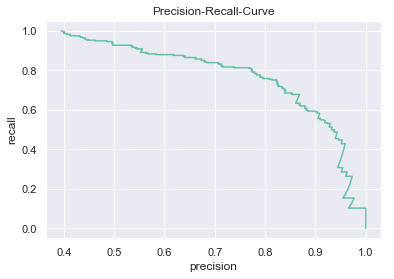

In [24]:
y_pred_prob = m.predict_proba(X_train)[:,1]
precision, recall, thresholds = precision_recall_curve(y_train, y_pred_prob)

plt.plot(precision, recall)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('Precision-Recall-Curve')
plt.show()

### Random Forest

In [25]:
rf_model = RandomForestRegressor (n_estimators=100, oob_score=True, random_state=42 )

In [26]:
rf_model.fit(X_test,y_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [27]:
rf_model.oob_score_

0.2552171074882864

In [28]:
y_oob = rf_model.oob_prediction_

In [29]:
"C-stat: ", roc_auc_score(y_test, y_oob)

('C-stat: ', 0.8029644268774704)

### Crossvalidation

In [30]:
scores = cross_val_score(rf_model, X_test,y_test, cv=5)
print(scores)

[ 0.26676571 -0.10561625  0.3804125   0.0019      0.45433388]


In [31]:
print(sum(scores)/5)

0.19955916917293234


In [32]:
for ntrees in range(1,20,3):
    for depth in range (1,11):
        rf_model = RandomForestClassifier(max_depth=depth, n_estimators=ntrees)
        scores = cross_val_score(rf_model, X_test,y_test, cv=5)
        print(ntrees, depth, sum(scores)/5)

1 1 0.6826984126984127
1 2 0.6931746031746031
1 3 0.7033333333333334
1 4 0.7098412698412698
1 5 0.7038095238095238
1 6 0.7206349206349206
1 7 0.6761904761904762
1 8 0.7317460317460318
1 9 0.7376190476190476
1 10 0.7042857142857143
4 1 0.7212698412698413
4 2 0.7325396825396825
4 3 0.776984126984127
4 4 0.7711111111111112
4 5 0.7487301587301587
4 6 0.7431746031746032
4 7 0.776984126984127
4 8 0.7260317460317461
4 9 0.7598412698412698
4 10 0.7317460317460318
7 1 0.7434920634920636
7 2 0.7826984126984128
7 3 0.7826984126984128
7 4 0.7877777777777778
7 5 0.7822222222222223
7 6 0.7711111111111112
7 7 0.7601587301587303
7 8 0.7547619047619049
7 9 0.7487301587301587
7 10 0.7763492063492065
10 1 0.7715873015873016
10 2 0.7882539682539682
10 3 0.7826984126984128
10 4 0.7880952380952382
10 5 0.7768253968253969
10 6 0.7598412698412698
10 7 0.7655555555555555
10 8 0.7879365079365079
10 9 0.7601587301587303
10 10 0.7323809523809524
13 1 0.7657142857142858
13 2 0.7601587301587303
13 3 0.7549206349206

In [33]:
rf_model = RandomForestClassifier(random_state=42)
params = {
    'max_depth':[2,3,4,5,6],
    'n_estimators':[1,3,5,7,10,15,20]
}
g = GridSearchCV(rf_model, param_grid=params)
g.fit (X_test,y_test)
g.score(X_test,y_test)

C:\Users\steff\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8435754189944135

In [34]:
g.best_params_

{'max_depth': 4, 'n_estimators': 3}

In [35]:
g.cv_results_['mean_test_score'].reshape((5,7))

array([[0.78212291, 0.78212291, 0.75418994, 0.77094972, 0.76536313,
        0.75977654, 0.75418994],
       [0.74301676, 0.78212291, 0.77094972, 0.78212291, 0.7877095 ,
        0.78212291, 0.78212291],
       [0.72625698, 0.79888268, 0.79329609, 0.79329609, 0.79329609,
        0.78212291, 0.76536313],
       [0.63128492, 0.77094972, 0.78212291, 0.75418994, 0.77094972,
        0.77094972, 0.76536313],
       [0.69832402, 0.72625698, 0.76536313, 0.77653631, 0.77094972,
        0.77094972, 0.77094972]])

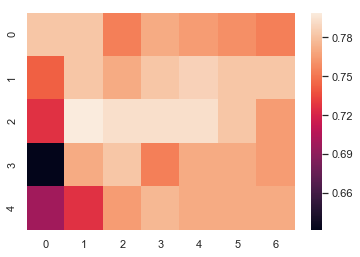

In [36]:
mtx= g.cv_results_['mean_test_score'].reshape((5,7))
sns.heatmap(mtx)